In [1]:
import numpy as np
import numpy.linalg as npl
import scipy as sp
import scipy.sparse.linalg as spspl
import matplotlib.pyplot as plt

## offline procedure
(not dependant of the problem)

In [2]:
def POD_offline_procedure(total_model_solver,training_set,tol,plot = False):
    U_delta_list = []
    for mu_loop in training_set:
        if plot:
            coucou = total_model_solver(mu_loop,True)
            plt.plot(coucou[0],coucou[1],label = str(mu_loop))
            U_delta_list.append(coucou[1])
        else:
            U_delta_list.append(total_model_solver(mu_loop))
    if plot:
        #plt.legend()
        plt.title("all different solutions for mu in training_set")
        plt.show()
    U_delta = np.array(U_delta_list)
    U,S,V = svd(U_delta)
    cumul_relat_vp = 0
    sum_vp = np.sum(S)
    for rank,vp in enumerate(S):
        cumul_relat_vp += vp/sum_vp
        if 1-cumul_relat_vp < tol:
            tronk_rank = rank
            break
    U_tr = U[:,:tronk_rank+1]
    return U_delta.T.dot(U_tr),1-cumul_relat_vp

In [3]:
def svd(U_delta):
    """
    This is not a simple svd, it's a svd-based algorithm described in 
    "Linear algebra box: Proper Orthogonal Decomposition (POD)" p.33
    """
    N,M = U_delta.shape
    wU = U_delta/np.sqrt(M)
    U,s,V = npl.svd(wU,False)
    S = s**2
    return U,S,V

In [4]:
def training_set_creator(*args):
    """
    args are a non-zero number of lists of size 3.
    Example of use: we want the creation of an iteratable representing all possible elements on a n-dimensional grid
    first dimension goes from a to b with c elements, then you pass "[a,b,c]" as a first argument.
    return: n-dimensional grid on which you can iterate.
    
    """
    linspace_args = (np.linspace(arg[0],arg[1],arg[2]) for arg in args)
    pools = [tuple(pool) for pool in linspace_args]
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield tuple(prod)

In [5]:
def reduced_solver(mu,A_q,shape):
    """
    from output of pre_computer and a mu: computes A_rb and f_rb and u_rb, the solution of A_rb.u_rb=f_rb
    """
    A = A_q[1]
    f = A_q[3]
    for i in range(shape):
        A += A_q[0][i]*mu[i]
    for i in range(shape,len(mu)):
        f += A_q[2][i-shape]*mu[i]
    return npl.solve(A,f)

## Problem-dependant part
(solver is the true solver, pre_computes creates A_rb^q matrices and f_rb^q vectors)

In [6]:
def solver(mu,plot = False):
    # 2 args
    # mu = [lambda_0, T_0]
    n = 5
    N_diff = 2**n
    x_diff_plot = sp.linspace(0,1,N_diff+2)
    x_diff = x_diff_plot[:-1]
    f_diff = np.zeros(len(x_diff))
    f_diff[0] = 1
    
    #construction de la matrice A en format sparse
    tab_A_0 = [np.repeat([1,0],[N_diff//2,N_diff//2],0),np.repeat([0,-2,-1,0],[1,N_diff//2-1,1,N_diff//2],0),np.repeat([0,1,0],[1,N_diff//2-1,N_diff//2],0)]
    tab_A_1 = [np.repeat([0,((N_diff+2)**2)],[N_diff//2,N_diff//2],0),np.repeat([1,0,-((N_diff+2)**2),-2*((N_diff+2)**2)],[1,N_diff//2-1,1,N_diff//2],0),np.repeat([0,((N_diff+2)**2)],[N_diff//2,N_diff//2],0)]
    #print(N_diff+1,len(tab_A_0[0]),len(tab_A_0[1]),len(tab_A_0[2]),"\n",len(tab_A_1[0]),len(tab_A_1[1]),len(tab_A_1[2]))
    A_0 = sp.sparse.diags(tab_A_0,[-1,0,1],(N_diff+1,N_diff+1))*((N_diff+2)**2)
    A_1 = sp.sparse.diags(tab_A_1,[-1,0,1],(N_diff+1,N_diff+1))
    #NPA_0 = A_0.todense()
    #NPA_1 = A_1.todense()
    #print(NPA_0+NPA_1)
    #print(NPA_1)

    #print(mu)
    A = A_1 + mu[0]*A_0
    f = mu[1] * f_diff
    #résolution des diff finies (Au=f)
    U_diff = spspl.spsolve(A,f)

    #préparation au plot
    U_diff_plot = sp.zeros(N_diff+2)
    U_diff_plot[:-1] = U_diff
    
    if plot:
        return x_diff_plot, U_diff_plot
    
    return U_diff_plot

In [7]:
#résolution par diff finies
def pre_computer(Base):
    """
    pre_computer take as input a reduced_base and pre_computes all quantities used for a reduced_solver.
    output: [[A_rb^q](0<= i <=n1),A_rb^0,[f_rb^q](0<= i <=n2),f_rb^0],n
    with A_rb = sum_(i in 0..n1){ mu[i]*A_rb^(q_1)_i } + A_rb^0
    and  f_rb = sum_(i in n1+1..n2){ mu[i]*f_rb^(q_1)_i } + f_rb^0
            n = n1+1
    """
    n = 5
    N_diff = 2**n
    f_diff = np.zeros(N_diff+2)
    f_diff[0] = 1
    
    #construction des matrices A en format sparse
    tab_A_0 = [np.repeat([1,0],[N_diff//2,N_diff//2+1],0),np.repeat([0,-2,-1,0],[1,N_diff//2-1,1,N_diff//2+1],0),np.repeat([0,1,0],[1,N_diff//2-1,N_diff//2+1],0)]
    tab_A_1 = [np.repeat([0,((N_diff+2)**2),0],[N_diff//2,N_diff//2,1],0),np.repeat([1,0,-((N_diff+2)**2),-2*((N_diff+2)**2),1],[1,N_diff//2-1,1,N_diff//2,1],0),np.repeat([0,((N_diff+2)**2)],[N_diff//2,N_diff//2+1],0)]
    A_0 = sp.sparse.diags(tab_A_0,[-1,0,1],(N_diff+2,N_diff+2))*((N_diff+2)**2)
    A_1 = sp.sparse.diags(tab_A_1,[-1,0,1],(N_diff+2,N_diff+2))
    
    #A = A_1 + mu[0]*A_0
    #f = mu[1] * f_diff
    return [[Base.T.dot(A_0.todense().dot(Base))],Base.T.dot(A_1.todense().dot(Base)),[Base.T.dot(f_diff)],Base.T.dot(np.zeros(f_diff.shape))],1

## Resolution

In [8]:
### computes POD_Base
T0 = np.array([1,50,50])
T1 = np.array([1,5,100])
training_set = training_set_creator(T0,T1)
Base,error = POD_offline_procedure(solver,training_set,0.0001)

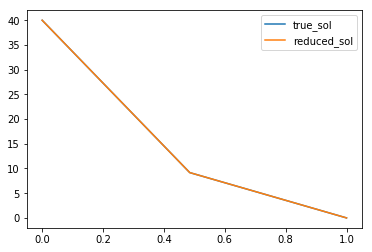

2.63016497470403e-10


In [9]:
### From Base, fast evaluates u_rb(mu_test)
A_q,shape = pre_computer(Base)
mu_test = (0.28,40)
U_rb = reduced_solver(mu_test,A_q,shape)
X,U_true = solver(mu_test,plot = True)
plt.plot(X,U_true,label="true_sol")
plt.plot(X,Base.dot(U_rb),label="reduced_sol")
plt.legend()
plt.show()
print(np.sum(np.abs(U_true-Base.dot(U_rb))))

## ancien code
(nothing useful now)

In [ ]:
class dimension_not_allowed_error(Exception):
    def __init__(self,l,k):
        self.l = l
        self.k = k
    def __str__(self):
        return "An error has occured while adding a new vector of size "+str(self.k)+" in basis of space of size "+str(self.l)

class base_orthonormee:
    
    def __init__(self,l,ps):
        self.Cardinal = 0
        self.Length = l
        self.Scalar_Product = ps
        self.Basis_Set = np.zeros((self.Length,self.Cardinal))
    
    def add(self,v):
        if self.Length != len(v):
            raise dimension_not_allowed_error(self.Length,len(v))
        v -= self.Scalar_Product(self.Basis_Set.T,self.Scalar_Product(self.Basis_Set,v))
        self.Basis_Set = np.concatenate((self.Basis_Set,v/np.sqrt(self.Scalar_Product(v,v))),axis=1)
        self.Cardinal += 1
    
    def matrix(self):
        return self.Basis_Set
    
    def show(self):
        print("vector length : ",self.Length)
        print("cardinal : ",self.Cardinal)
        print("matrix : ",self.Basis_Set)

def offline_procedure(total_model_solver,reduced_basis_solver,ps,pre_computing,training_set,tol,l):
    """ 
    this function takes the problem and a sample of the parameter space and computes the reduced basis
    (following greedy algorithm steps) that approximates the space (V_delta) so that the maximum error is less than the tolerance.
    
        function "total model solver" is the true solver.
                                                Input: mu
                                                Output: u_delta(mu)
        function "reduced basis solver" solves the linear system A^mu_rb . u^mu_rb = f^mu_rb
                                                Input: mu, Ta, Tf (pre_computed elements of A and f)
                                                Output: u_rb(mu), s_rb(mu) = nu(mu)
        function "ps" is the scalar product for normalization and orthogonalization.
                                                Input: 2 vectors
                                                Output: scalar_product result
        function "pre computing" performs the precomputing step
                                                Input: V (current V_rb basis)
                                                Ouput: Ta,Tf (na partial A-matrices and nf f-vectors from affine assumption)
        array "training set" is the sample of the parameter space
        
        float "tol" is the tolerance for stopping criteria
        
        integer "l" determines current vector length
        
    """
    mu = training_set[0]
    max_nu = np.Inf
    V = base_orthonormee(l,ps)
    while max_nu > tol:
        #gram-schmidt pour que V ressemble à une base
        V.add(total_model_solver(mu))
        #pre-computing
        Ta,Tf = pre_computing(V.matrix)
        #calcul de u_rb(mu) pour tout les mu
        max_nu = 0
        for mu_loop in training_set :
            u_rb,nu = reduced_basis_solver(Ta,Tf,mu_loop)
            if max_nu < nu and nu > tol:
                max_nu = nu
                mu = mu_loop
    return V
        

In [ ]:
def ps(u,v):
    return u.T.dot(v)
def pre_computing(V):
    

In [ ]:
## Test base orthonormee
#v1 = np.zeros((3,1))
#v2 = np.zeros((3,1))
#v3 = np.zeros((3,1))
#v1 = np.asarray([[1.],[1.],[1.]])
#v2 = np.asarray([[1.],[-1.],[0.]])
#v3 = np.asarray([[-1.],[-9.],[-9.]])
#test = base_orthonormee(v1,ps)
#test.show()
#test.add(v2)
#test.show()
#test.add(v3)
#test.show()